In [555]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

# Описание столбцов и загрузка датасета

- train.csv - персональные данные пассажиров
    * PassengerId - уникальный айди каждого пассажира в формате gggg_pp, где gggg - обозначает группу пассажира, pp - номер внутри группы.
    * HomePlanet - планета, с которой пассажир вылетел, обычно планета постоянного проживания.
    * CryoSleep - указывает, согласился ли пассажир на анабиоз на время путешествия. Пассажиры, находящиеся в криосне, находятся в своих каютах.
    * Cabin - номер каюты, в которой находится пассажир. Имеет вид deck/num/side, где side может быть P (левый борт) или S (правый борт).
    * Destination - планета, на которую пассажир высадится.
    * Age - возраст пассажира.
    * VIP - оплатил ли пассажир специальное VIP-обслуживание во время путешествия.
    * RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - сумма, оплаченная пассажиром за каждый из многочисленных роскошных удобств космического корабля «Титаник».
    * Name - имя и фамилия пассажира.
    * Transported - был ли пассажир перенесен в другое измерение. Это и есть цель, столбец, который вы пытаетесь предсказать.
- test.csv — Личные данные оставшейся трети (~4300) пассажиров, которые будут использованы в качестве тестовых данных. Ваша задача — предсказать значение «Перевезено» для пассажиров из этого набора.
- sample_submission.csv - файл отправки в правильном формате.
    * PassengerId — идентификатор каждого пассажира в тестовом наборе.
    * Transfered — целевой объект. Для каждого пассажира предскажите значение True или False.

In [556]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Заполнение пропусков

In [557]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [558]:
# Display basic information about the training dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [559]:
# Check for missing values in the training dataset
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<Axes: >

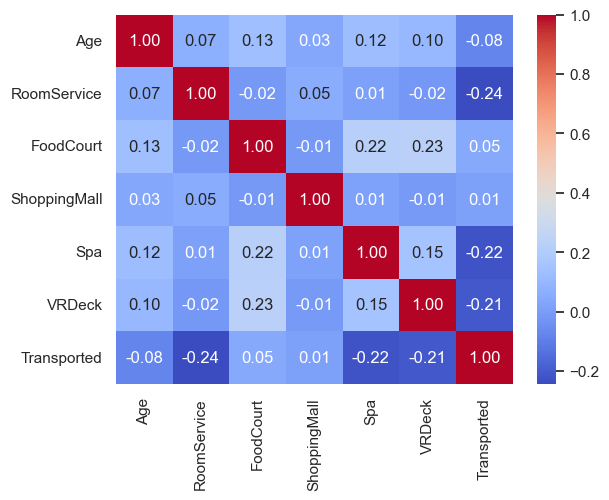

In [560]:
# Heatmap to visualize correlations
corr_matrix = train.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

## Проставим пропуски в CryoSleep и сервисах

In [561]:
# Analyze relationships between sum of services and CryoSleep status
train[train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck'] < 100]['CryoSleep'].value_counts()

CryoSleep
True     2690
False     470
Name: count, dtype: int64

видно, что если человек тратил на сервисы очень мало, то он с большой вероятностью находился в состоянии криосна
поэтому можно заполнить пустые значения в столбце CryoSleep как True, если траты были минимальные и на False, если они были относительно большими

In [562]:
# вставим значения в CryoSleep на основе расходов на сервисы
train.loc[(train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck'] < 100) & (train['CryoSleep'].isnull()), 'CryoSleep'] = True
test.loc[(test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck'] < 100) & (test['CryoSleep'].isnull()), 'CryoSleep'] = True

In [563]:
train.loc[(train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck'] >= 100) & (train['CryoSleep'].isnull()), 'CryoSleep'] = False
test.loc[(test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck'] >= 100) & (test['CryoSleep'].isnull()), 'CryoSleep'] = False

остались еще нановые значения, это значит, что столбцы сервисов с нанами


In [564]:
# заполним пропуски в сервисах нулями если остальные сервисы равны нулю
train.loc[(train['RoomService'].isnull()) & (train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck'] == 0), 'RoomService'] = 0
train.loc[(train['FoodCourt'].isnull()) & (train['RoomService'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck'] == 0), 'FoodCourt'] = 0
train.loc[(train['ShoppingMall'].isnull()) & (train['RoomService'] + train['FoodCourt'] + train['Spa'] + train['VRDeck'] == 0), 'ShoppingMall'] = 0
train.loc[(train['Spa'].isnull()) & (train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['VRDeck'] == 0), 'Spa'] = 0
train.loc[(train['VRDeck'].isnull()) & (train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] == 0), 'VRDeck'] = 0

test.loc[(test['RoomService'].isnull()) & (test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck'] == 0), 'RoomService'] = 0
test.loc[(test['FoodCourt'].isnull()) & (test['RoomService'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck'] == 0), 'FoodCourt'] = 0
test.loc[(test['ShoppingMall'].isnull()) & (test['RoomService'] + test['FoodCourt'] + test['Spa'] + test['VRDeck'] == 0), 'ShoppingMall'] = 0
test.loc[(test['Spa'].isnull()) & (test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['VRDeck'] == 0), 'Spa'] = 0
test.loc[(test['VRDeck'].isnull()) & (test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] == 0), 'VRDeck'] = 0

In [565]:
# остальные пропуски заполним медианой
train['RoomService'] = train['RoomService'].fillna(train['RoomService'].median())
train['FoodCourt'] = train['FoodCourt'].fillna(train['FoodCourt'].median())
train['ShoppingMall'] = train['ShoppingMall'].fillna(train['ShoppingMall'].median())
train['Spa'] = train['Spa'].fillna(train['Spa'].median())
train['VRDeck'] = train['VRDeck'].fillna(train['VRDeck'].median())

test['RoomService'] = test['RoomService'].fillna(test['RoomService'].median())
test['FoodCourt'] = test['FoodCourt'].fillna(test['FoodCourt'].median())
test['ShoppingMall'] = test['ShoppingMall'].fillna(test['ShoppingMall'].median())
test['Spa'] = test['Spa'].fillna(test['Spa'].median())
test['VRDeck'] = test['VRDeck'].fillna(test['VRDeck'].median())

In [566]:
# вставим значения в CryoSleep на основе расходов на сервисы
train.loc[(train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck'] < 100) & (train['CryoSleep'].isnull()), 'CryoSleep'] = True
train.loc[(train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck'] >= 100) & (train['CryoSleep'].isnull()), 'CryoSleep'] = False

test.loc[(test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck'] < 100) & (test['CryoSleep'].isnull()), 'CryoSleep'] = True
test.loc[(test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck'] >= 100) & (test['CryoSleep'].isnull()), 'CryoSleep'] = False

In [567]:
train['CryoSleep'].isnull().sum()

np.int64(0)

In [568]:
test['CryoSleep'].isnull().sum()

np.int64(0)

## Декомпозируем Cabin

In [569]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [570]:
# смотрим на пропуски в Cabin
train['Cabin'].isnull().sum()

np.int64(199)

## Заполним пропуски в HomePlanet и Cabin

In [571]:
# Extract group IDs from PassengerId
train['GroupId'] = train['PassengerId'].str.split('_').str[0]
test['GroupId'] = test['PassengerId'].str.split('_').str[0]
# Analyze if passengers in the same group share HomePlanet
group_planet_analysis = train.groupby('GroupId')['HomePlanet'].nunique()
print("\nGroups with different HomePlanets:", (group_planet_analysis > 1).sum())
print("Total groups:", len(group_planet_analysis))
print("\nPercentage of groups with same HomePlanet:", 
      ((group_planet_analysis == 1).sum() / len(group_planet_analysis) * 100).round(2), "%")

# Analyze if passengers in the same group share Cabin
group_cabin_analysis = train.groupby('GroupId')['Cabin'].nunique()
print("\nGroups with different Cabins:", (group_cabin_analysis > 1).sum())
print("Total groups:", len(group_cabin_analysis))
print("\nPercentage of groups with same Cabin:", 
      ((group_cabin_analysis == 1).sum() / len(group_cabin_analysis) * 100).round(2), "%")


Groups with different HomePlanets: 0
Total groups: 6217

Percentage of groups with same HomePlanet: 98.23 %

Groups with different Cabins: 421
Total groups: 6217

Percentage of groups with same Cabin: 91.64 %


из этого блока кода, можно понять, что люди из одной группы почти всегда из одной планеты и одной кабины, поэтому можно вставить их

In [572]:
# Fill missing HomePlanet values based on group
def fill_from_group(group):
    if group['HomePlanet'].isnull().any():
        non_null_planet = group['HomePlanet'].dropna().iloc[0] if not group['HomePlanet'].dropna().empty else None
        if non_null_planet:
            group['HomePlanet'] = group['HomePlanet'].fillna(non_null_planet)
    return group

# Print number of missing values before
print("Missing HomePlanet values before:", train['HomePlanet'].isnull().sum())

# Fill missing values
train = train.groupby('GroupId', group_keys=False).apply(fill_from_group)

# Print number of missing values after
print("Missing HomePlanet values after:", train['HomePlanet'].isnull().sum())

# Fill remaining missing values with mode
if train['HomePlanet'].isnull().sum() > 0:
    train['HomePlanet'] = train['HomePlanet'].fillna(train['HomePlanet'].mode()[0])
    print("Missing HomePlanet values after mode fill:", train['HomePlanet'].isnull().sum())

# same for test set
test = test.groupby('GroupId', group_keys=False).apply(fill_from_group)
if test['HomePlanet'].isnull().sum() > 0:
    test['HomePlanet'] = test['HomePlanet'].fillna(test['HomePlanet'].mode()[0])

Missing HomePlanet values before: 201


C:\Users\ysnxlmted\AppData\Local\Temp\ipykernel_10776\2104996039.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby('GroupId', group_keys=False).apply(fill_from_group)


Missing HomePlanet values after: 111
Missing HomePlanet values after mode fill: 0


C:\Users\ysnxlmted\AppData\Local\Temp\ipykernel_10776\2104996039.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = test.groupby('GroupId', group_keys=False).apply(fill_from_group)


In [573]:
# Decompose Cabin into its components
train[['Deck', 'Num', 'Side']] = train['Cabin'].str.split('/', expand=True)
test[['Deck', 'Num', 'Side']] = test['Cabin'].str.split('/', expand=True)

In [574]:
# Fill missing Cabin values based on group
def fill_cabin_from_group(group):
    if group['Cabin'].isnull().any():
        non_null_cabin = group['Cabin'].dropna().iloc[0] if not group['Cabin'].dropna().empty else None
        if non_null_cabin:
            group['Cabin'] = group['Cabin'].fillna(non_null_cabin)
            group[['Deck', 'Num', 'Side']] = group['Cabin'].str.split('/', expand=True)
    return group

# Print number of missing values before
print("Missing Cabin values before:", train['Cabin'].isnull().sum())

# Fill missing values based on group
train = train.groupby('GroupId', group_keys=False).apply(fill_cabin_from_group)

# Print number of missing values after group fill
print("Missing Cabin values after group fill:", train['Cabin'].isnull().sum())

# For remaining missing values, fill with most common values per HomePlanet
if train['Cabin'].isnull().sum() > 0:
    # Create temporary df for remaining missing cabins
    missing_cabins = train[train['Cabin'].isnull()]
    
    # For each HomePlanet, find most common Deck and Side
    for planet in train['HomePlanet'].unique():
        planet_data = train[train['HomePlanet'] == planet]
        common_deck = planet_data['Deck'].mode()[0]
        common_side = planet_data['Side'].mode()[0]
        
        # Get next available cabin number for this deck
        max_num = train[train['Deck'] == common_deck]['Num'].astype(float).max()
        
        # Fill missing values for this planet
        planet_missing = missing_cabins[missing_cabins['HomePlanet'] == planet].index
        for idx, i in enumerate(planet_missing):
            new_num = str(int(max_num + idx + 1))
            train.loc[i, 'Cabin'] = f"{common_deck}/{new_num}/{common_side}"
            train.loc[i, ['Deck', 'Num', 'Side']] = [common_deck, new_num, common_side]

print("Missing Cabin values after all fills:", train['Cabin'].isnull().sum())

#same for test set
test = test.groupby('GroupId', group_keys=False).apply(fill_cabin_from_group)
if test['Cabin'].isnull().sum() > 0:
    # Create temporary df for remaining missing cabins
    missing_cabins = test[test['Cabin'].isnull()]
    
    # For each HomePlanet, find most common Deck and Side
    for planet in test['HomePlanet'].unique():
        planet_data = test[test['HomePlanet'] == planet]
        common_deck = planet_data['Deck'].mode()[0]
        common_side = planet_data['Side'].mode()[0]
        
        # Get next available cabin number for this deck
        max_num = test[test['Deck'] == common_deck]['Num'].astype(float).max()
        
        # Fill missing values for this planet
        planet_missing = missing_cabins[missing_cabins['HomePlanet'] == planet].index
        for idx, i in enumerate(planet_missing):
            new_num = str(int(max_num + idx + 1))
            test.loc[i, 'Cabin'] = f"{common_deck}/{new_num}/{common_side}"
            test.loc[i, ['Deck', 'Num', 'Side']] = [common_deck, new_num, common_side]



Missing Cabin values before: 199


C:\Users\ysnxlmted\AppData\Local\Temp\ipykernel_10776\1994848782.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby('GroupId', group_keys=False).apply(fill_cabin_from_group)


Missing Cabin values after group fill: 99
Missing Cabin values after all fills: 0


C:\Users\ysnxlmted\AppData\Local\Temp\ipykernel_10776\1994848782.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = test.groupby('GroupId', group_keys=False).apply(fill_cabin_from_group)


# Заполним пропуски в Destination

In [575]:
# Анализ связи между группами и планетой назначения (Destination)
group_destination_analysis = train.groupby('GroupId')['Destination'].nunique()
print("Процент групп с одинаковым пунктом назначения:", 
      ((group_destination_analysis == 1).sum() / len(group_destination_analysis) * 100).round(2), "%")

Процент групп с одинаковым пунктом назначения: 86.81 %


In [576]:
# Функция для заполнения пропусков на основе группы
def fill_destination_from_group(group):
    if group['Destination'].isnull().any():
        non_null_dest = group['Destination'].dropna().iloc[0] if not group['Destination'].dropna().empty else None
        if non_null_dest:
            group['Destination'] = group['Destination'].fillna(non_null_dest)
    return group

# Заполняем пропуски на основе группы
train = train.groupby('GroupId', group_keys=False).apply(fill_destination_from_group)

# Для оставшихся пропусков используем наиболее частое значение для соответствующей HomePlanet
for planet in train['HomePlanet'].unique():
    planet_mode = train[train['HomePlanet'] == planet]['Destination'].mode()[0]
    mask = (train['HomePlanet'] == planet) & (train['Destination'].isnull())
    train.loc[mask, 'Destination'] = planet_mode

# Аналогично для тестового набора
test = test.groupby('GroupId', group_keys=False).apply(fill_destination_from_group)
if test['Destination'].isnull().sum() > 0:
    for planet in test['HomePlanet'].unique():
        planet_mode = test[test['HomePlanet'] == planet]['Destination'].mode()[0]
        mask = (test['HomePlanet'] == planet) & (test['Destination'].isnull())
        test.loc[mask, 'Destination'] = planet_mode


C:\Users\ysnxlmted\AppData\Local\Temp\ipykernel_10776\4142244414.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby('GroupId', group_keys=False).apply(fill_destination_from_group)
C:\Users\ysnxlmted\AppData\Local\Temp\ipykernel_10776\4142244414.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = test.groupby('GroupId', group_keys=False).apply(fill_destination_from_group)


## Заполнение VIP

In [577]:
# Рассчитаем средние траты для VIP и не-VIP пассажиров
vip_spending = train[train['VIP'] == True][['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()
non_vip_spending = train[train['VIP'] == False][['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()

# Создаем DataFrame для сравнения
comparison = pd.DataFrame({
    'VIP': vip_spending,
    'Non-VIP': non_vip_spending
})
comparison['Разница (в разы)'] = (comparison['VIP'] / comparison['Non-VIP']).round(2)

print("Средние траты VIP vs не-VIP пассажиров:")
print(comparison)

Средние траты VIP vs не-VIP пассажиров:
                      VIP     Non-VIP  Разница (в разы)
RoomService    464.095477  212.686045              2.18
FoodCourt     1756.778894  417.440598              4.21
ShoppingMall   241.502513  169.702931              1.42
Spa            753.065327  295.197202              2.55
VRDeck        1210.035176  276.477868              4.38


In [578]:
# Рассчитаем общие траты для каждого пассажира
train['total_spending'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']

# Находим пороговое значение трат (25-й перцентиль VIP-пассажиров)
spending_threshold = train[train['VIP'] == True]['total_spending'].quantile(0.25)

# Заполняем пропуски в VIP на основе общих трат
train.loc[train['VIP'].isnull() & (train['total_spending'] >= spending_threshold), 'VIP'] = True
train.loc[train['VIP'].isnull() & (train['total_spending'] < spending_threshold), 'VIP'] = False

# Аналогично для тестового набора
test['total_spending'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']
test.loc[test['VIP'].isnull() & (test['total_spending'] >= spending_threshold), 'VIP'] = True
test.loc[test['VIP'].isnull() & (test['total_spending'] < spending_threshold), 'VIP'] = False

In [579]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     8693 non-null   object 
 1   HomePlanet      8693 non-null   object 
 2   CryoSleep       8693 non-null   object 
 3   Cabin           8693 non-null   object 
 4   Destination     8693 non-null   object 
 5   Age             8514 non-null   float64
 6   VIP             8693 non-null   object 
 7   RoomService     8693 non-null   float64
 8   FoodCourt       8693 non-null   float64
 9   ShoppingMall    8693 non-null   float64
 10  Spa             8693 non-null   float64
 11  VRDeck          8693 non-null   float64
 12  Name            8493 non-null   object 
 13  Transported     8693 non-null   bool   
 14  GroupId         8693 non-null   object 
 15  Deck            8693 non-null   object 
 16  Num             8693 non-null   object 
 17  Side            8693 non-null   object

In [580]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0 to 4276
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     4277 non-null   object 
 1   HomePlanet      4277 non-null   object 
 2   CryoSleep       4277 non-null   object 
 3   Cabin           4277 non-null   object 
 4   Destination     4277 non-null   object 
 5   Age             4186 non-null   float64
 6   VIP             4277 non-null   object 
 7   RoomService     4277 non-null   float64
 8   FoodCourt       4277 non-null   float64
 9   ShoppingMall    4277 non-null   float64
 10  Spa             4277 non-null   float64
 11  VRDeck          4277 non-null   float64
 12  Name            4183 non-null   object 
 13  GroupId         4277 non-null   object 
 14  Deck            4277 non-null   object 
 15  Num             4277 non-null   object 
 16  Side            4277 non-null   object 
 17  total_spending  4277 non-null   float6

# Анализ связи между группой и фамилией пассажиров

In [581]:
# Извлечем фамилии из полного имени
train['LastName'] = train['Name'].str.split(' ').str[-1]

# Анализируем, сколько разных фамилий в каждой группе
group_lastname_analysis = train.groupby('GroupId')['LastName'].nunique()

print("Процент групп с одинаковой фамилией:", 
      ((group_lastname_analysis == 1).sum() / len(group_lastname_analysis) * 100).round(2), "%")

Процент групп с одинаковой фамилией: 94.32 %


In [582]:
# Проверим количество пропущенных значений в именах
print("Пропущенных имен до заполнения:", train['Name'].isnull().sum())

# Функция для заполнения пропущенных фамилий на основе группы
def fill_lastname_from_group(group):
    if group['Name'].isnull().any():
        # Получаем фамилию группы из непустых значений
        non_null_names = group['Name'].dropna()
        if not non_null_names.empty:
            group_lastname = non_null_names.iloc[0].split()[-1]
            # Для пропущенных имен создаем временное имя с фамилией группы
            group.loc[group['Name'].isnull(), 'Name'] = 'Unknown ' + group_lastname
            group.loc[group['Name'].isnull(), 'LastName'] = group_lastname
    return group

# Заполняем пропущенные имена
train = train.groupby('GroupId', group_keys=False).apply(fill_lastname_from_group)

print("Пропущенных имен после заполнения:", train['Name'].isnull().sum())

# Аналогично для тестового набора
test = test.groupby('GroupId', group_keys=False).apply(fill_lastname_from_group)

Пропущенных имен до заполнения: 200


C:\Users\ysnxlmted\AppData\Local\Temp\ipykernel_10776\2770705724.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby('GroupId', group_keys=False).apply(fill_lastname_from_group)


Пропущенных имен после заполнения: 104


C:\Users\ysnxlmted\AppData\Local\Temp\ipykernel_10776\2770705724.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = test.groupby('GroupId', group_keys=False).apply(fill_lastname_from_group)


Остальные едут одни, поэтому незнаю че с ними делать

# Создание фичей

<Axes: >

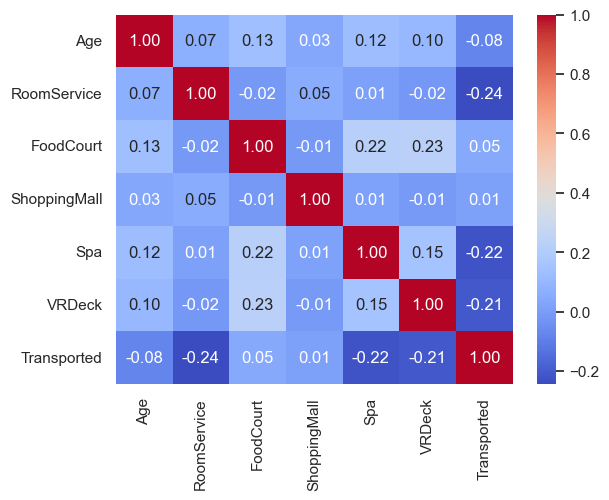

In [583]:
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

In [584]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,Deck,Num,Side,total_spending,LastName
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,0,P,0.0,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,0,S,736.0,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,0,S,10383.0,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,0,S,5176.0,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,1,S,1091.0,Santantines


## Фича -- сколько людей в группе

In [585]:
train['MemberCount'] = train.groupby('GroupId')['PassengerId'].transform('count')
test['MemberCount'] = test.groupby('GroupId')['PassengerId'].transform('count')

<Axes: xlabel='MemberCount', ylabel='Transported'>

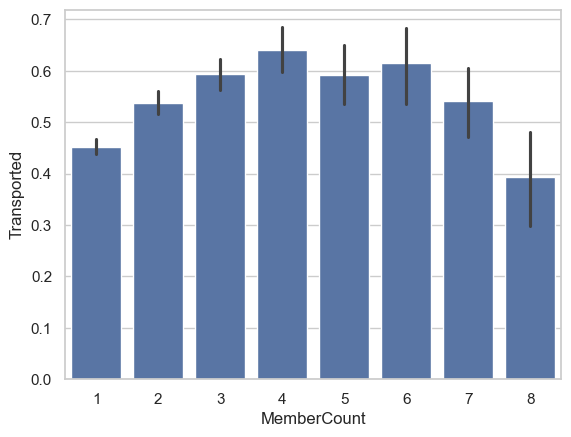

In [586]:
# посмотрим как связаны MemberCount и Transported
sns.barplot(x='MemberCount', y='Transported', data=train)

## Фича -- Deck

<Axes: xlabel='Deck', ylabel='Transported'>

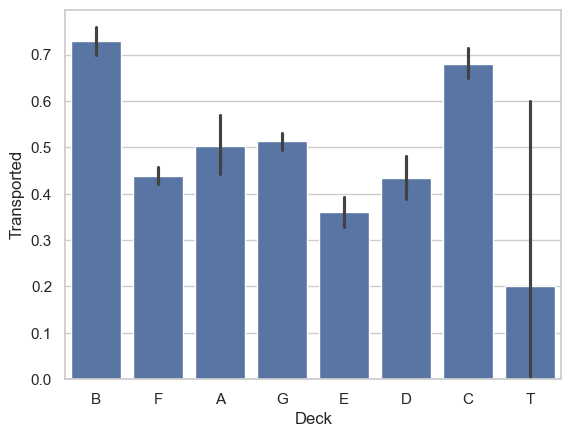

In [587]:
# посмотрим как связаны Deck и Transported
sns.barplot(x='Deck', y='Transported', data=train)

## Фича -- Age

<Axes: xlabel='Age'>

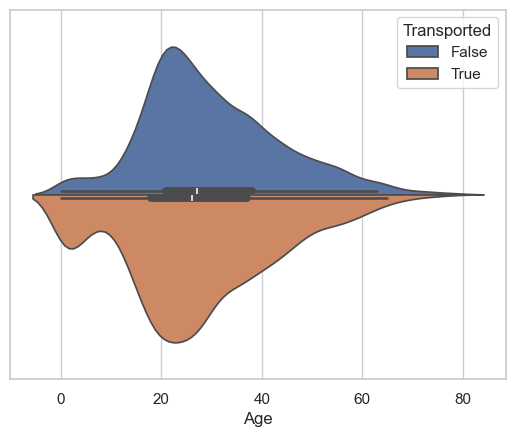

In [588]:
# посмотрим как связан возраст и Transported
sns.violinplot(x='Age', hue='Transported', data=train, split=True)

In [589]:
# разобьем возраст на категории
train['AgeGroup'] = pd.cut(train['Age'], bins=[0, 12, 18, 35, 50, 65, 100], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'MiddleAged', 'Senior'])
test['AgeGroup'] = pd.cut(test['Age'], bins=[0, 12, 18, 35, 50, 65, 100], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'MiddleAged', 'Senior'])

<Axes: xlabel='AgeGroup', ylabel='Transported'>

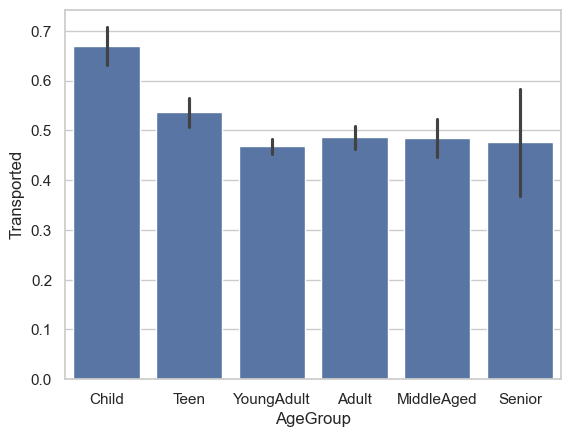

In [590]:
# посмотрим группы по возрасту и Transported
sns.barplot(x='AgeGroup', y='Transported', data=train)

In [591]:
# превратим возраст в числовой
train['AgeGroup'] = train['AgeGroup'].astype('category').cat.codes
test['AgeGroup'] = test['AgeGroup'].astype('category').cat.codes

## Фича -- Планета отправки - планета посадки

In [592]:
# создадим фичу - планета отправки - планета посадки
train['PlanetRoute'] = train['HomePlanet'] + '-' + train['Destination']
test['PlanetRoute'] = test['HomePlanet'] + '-' + test['Destination']

<Axes: xlabel='PlanetRoute', ylabel='Transported'>

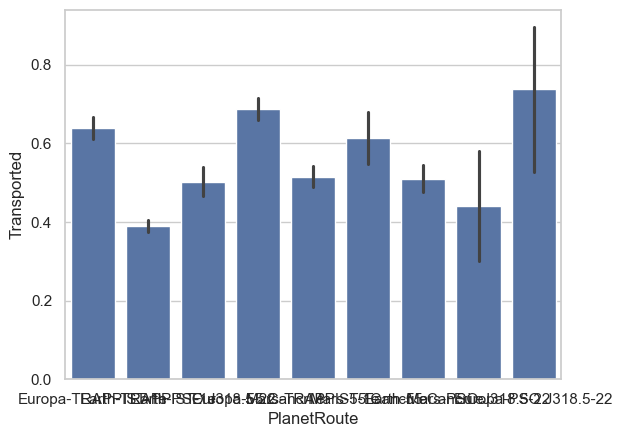

In [593]:
# проверим планету приземления и Transported
sns.barplot(x='PlanetRoute', y='Transported', data=train)

In [594]:
# превратим этот признак в числовой
train['PlanetRoute'] = train['PlanetRoute'].astype('category').cat.codes
test['PlanetRoute'] = test['PlanetRoute'].astype('category').cat.codes

<Axes: xlabel='PlanetRoute', ylabel='Transported'>

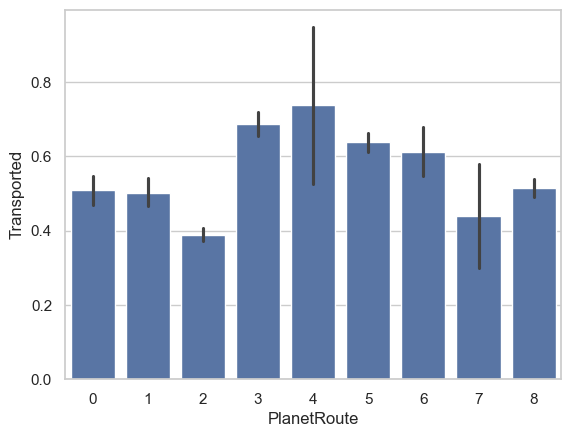

In [595]:
sns.barplot(x='PlanetRoute', y='Transported', data=train)

In [596]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,GroupId,Deck,Num,Side,total_spending,LastName,MemberCount,AgeGroup,PlanetRoute
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,0001,B,0,P,0.0,Ofracculy,1,3,5
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,0002,F,0,S,736.0,Vines,1,2,2
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,False,0003,A,0,S,10383.0,Susent,2,4,5
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,False,0003,A,0,S,5176.0,Susent,2,2,5
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,True,0004,F,1,S,1091.0,Santantines,1,1,2


## Фича -- сумма RoomService, Spa, VRDeck

видно, что эти три колонки дают большую кореляцию, чем все остальные, поэтому просуммируем их

In [597]:
# создадим фичу - сумма RoomService, Spa, VRDeck
train['LeisureSpending'] = train['RoomService'] + train['Spa'] + train['VRDeck']
test['LeisureSpending'] = test['RoomService'] + test['Spa'] + test['VRDeck']

<Axes: >

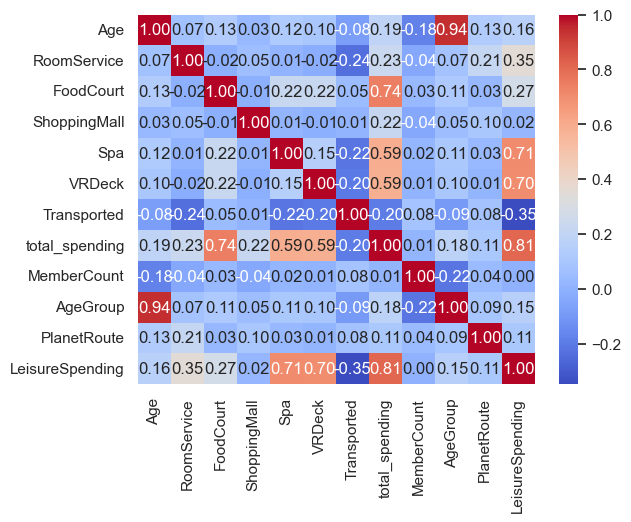

In [598]:
sns.heatmap(train.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')

## Фича -- вип-статус

In [599]:
# превратим вип-статус в числовой
train['VIP'] = train['VIP'].astype(int)
test['VIP'] = test['VIP'].astype(int)

In [600]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,GroupId,Deck,Num,Side,total_spending,LastName,MemberCount,AgeGroup,PlanetRoute,LeisureSpending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,...,0001,B,0,P,0.0,Ofracculy,1,3,5,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,...,0002,F,0,S,736.0,Vines,1,2,2,702.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,...,0003,A,0,S,10383.0,Susent,2,4,5,6807.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,...,0003,A,0,S,5176.0,Susent,2,2,5,3522.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,...,0004,F,1,S,1091.0,Santantines,1,1,2,870.0


## Фича --  Deck

<Axes: >

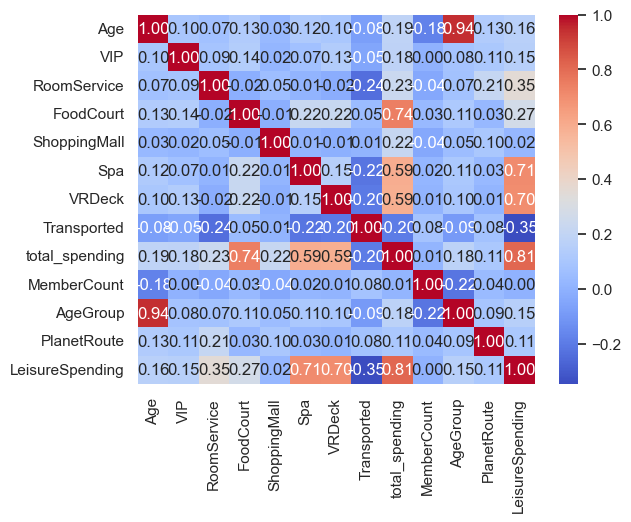

In [601]:
sns.heatmap(train.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')

## Фича -- сколько было в кабине взрослых

In [602]:
# Создадим столбец AdultInCabin, который считает количество взрослых (возраст >= 18) в одной кабине
train['AdultInCabin'] = train.groupby('Cabin')['Age'].transform(lambda x: (x >= 18).sum())
test['AdultInCabin'] = test.groupby('Cabin')['Age'].transform(lambda x: (x >= 18).sum())

# Проверим среднюю выживаемость исходя из фичи

## AdultInCabin vs. Transported

<Axes: xlabel='AdultInCabin', ylabel='Transported'>

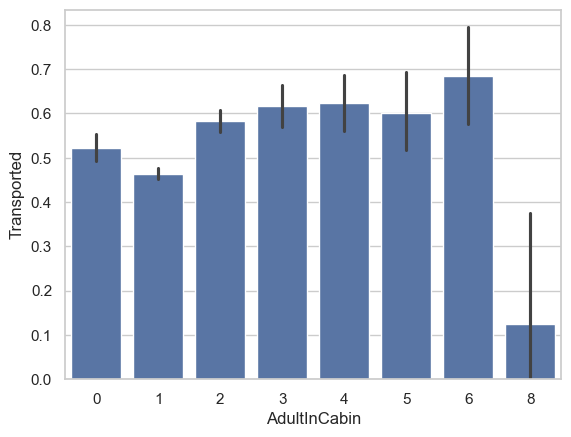

In [603]:
sns.barplot(x='AdultInCabin', y='Transported', data=train)

## AgeGroup vs. Transported

<Axes: xlabel='AgeGroup', ylabel='Transported'>

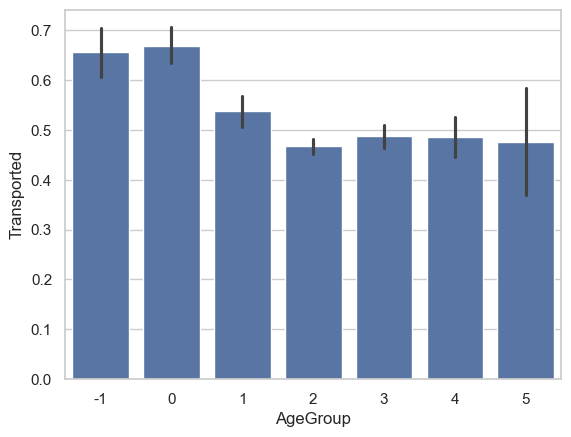

In [604]:
# посморим как статус transported зависит от возрастной группы
sns.barplot(x='AgeGroup', y='Transported', data=train)

In [605]:
# закодируем эту фичу через OneHotEncoding
train = pd.get_dummies(train, columns=['AgeGroup'], drop_first=True)
test = pd.get_dummies(test, columns=['AgeGroup'], drop_first=True)

In [606]:
# удалю Age
train = train.drop(columns=['Age'], axis=1)
test = test.drop(columns=['Age'], axis=1)

## PlanetRoute vs. Transported

<Axes: xlabel='PlanetRoute', ylabel='Transported'>

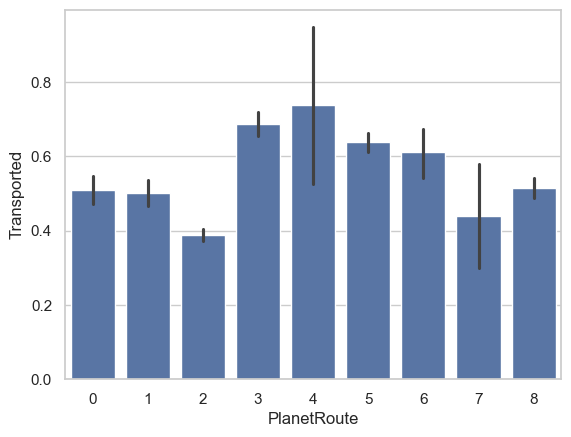

In [607]:
# посмотрим как planetroute зависит от transported
sns.barplot(x='PlanetRoute', y='Transported', data=train)

In [608]:
# закодируем этот признак через OneHotEncoding
train = pd.get_dummies(train, columns=['PlanetRoute'], drop_first=True)
test = pd.get_dummies(test, columns=['PlanetRoute'], drop_first=True)

## VIP vs. Transported 

<Axes: xlabel='VIP', ylabel='Transported'>

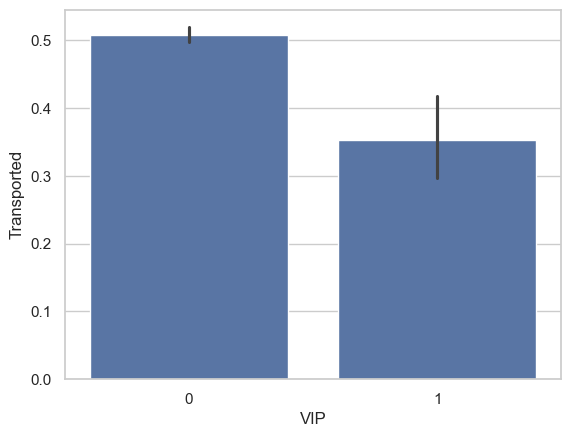

In [609]:
# посмотрим как VIP зависит от transported
sns.barplot(x='VIP', y='Transported', data=train)

In [610]:
# закодируем VIP через OneHotEncoding
train = pd.get_dummies(train, columns=['VIP'], drop_first=True)
test = pd.get_dummies(test, columns=['VIP'], drop_first=True)

## Удалим сервисы

In [611]:
# удалю сервисы так как есть LeisureSpending, в которой есть RoomService, Spa, VRDeck, хорошо коррелирующие с Transported
train = train.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spending'], axis=1) 
test = test.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spending'], axis=1)

## Deck vs. Transported

<Axes: xlabel='Deck', ylabel='Transported'>

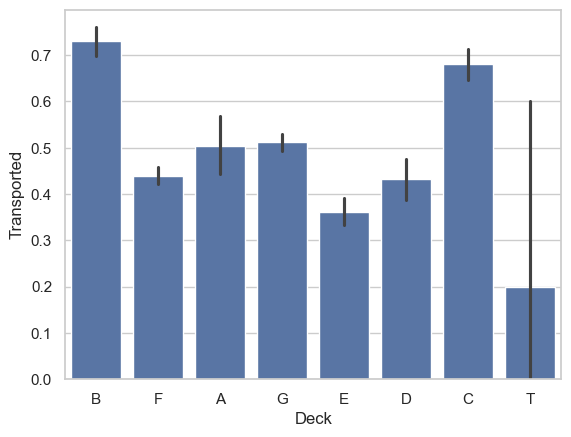

In [612]:
# посмотрим как deck зависит от transported
sns.barplot(x='Deck', y='Transported', data=train)

In [613]:
# закодируем Deck через OneHotEncoding
train = pd.get_dummies(train, columns=['Deck'], drop_first=True)
test = pd.get_dummies(test, columns=['Deck'], drop_first=True)

## MemberCount vs. Transported

<Axes: xlabel='MemberCount', ylabel='Transported'>

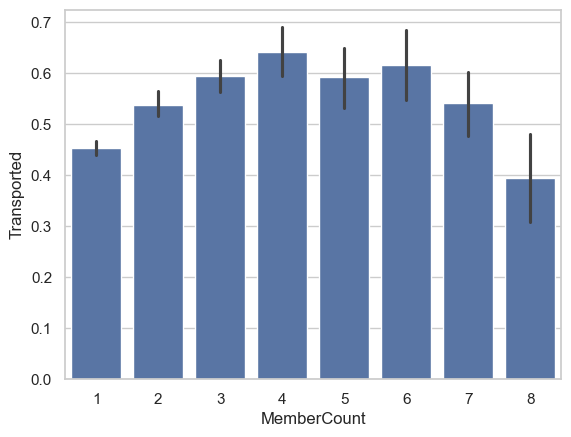

In [614]:
# посмотрим как MemberCount зависит от transported
sns.barplot(x='MemberCount', y='Transported', data=train)

In [615]:
# разобьем фичу с помощью OneHotEncoding
train = pd.get_dummies(train, columns=['MemberCount'], drop_first=True)
test = pd.get_dummies(test, columns=['MemberCount'], drop_first=True)

## Удаление всего ненужного

In [616]:
# удалим все, что не нужно
cols = train.columns
cols

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination',
       'Name', 'Transported', 'GroupId', 'Num', 'Side', 'LastName',
       'LeisureSpending', 'AdultInCabin', 'AgeGroup_0', 'AgeGroup_1',
       'AgeGroup_2', 'AgeGroup_3', 'AgeGroup_4', 'AgeGroup_5', 'PlanetRoute_1',
       'PlanetRoute_2', 'PlanetRoute_3', 'PlanetRoute_4', 'PlanetRoute_5',
       'PlanetRoute_6', 'PlanetRoute_7', 'PlanetRoute_8', 'VIP_1', 'Deck_B',
       'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'MemberCount_2', 'MemberCount_3', 'MemberCount_4', 'MemberCount_5',
       'MemberCount_6', 'MemberCount_7', 'MemberCount_8'],
      dtype='object')

In [617]:
train = train.drop(columns=['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name', 'GroupId', 'LastName', 'Num', 'Side'], axis=1)
test = test.drop(columns=['HomePlanet', 'Cabin', 'Destination', 'Name', 'GroupId', 'LastName', 'Num', 'Side'], axis=1)

In [618]:
train.head()

,CryoSleep,Transported,LeisureSpending,AdultInCabin,AgeGroup_0,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,...,Deck_F,Deck_G,Deck_T,MemberCount_2,MemberCount_3,MemberCount_4,MemberCount_5,MemberCount_6,MemberCount_7,MemberCount_8
0,False,False,0.0,1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,702.0,1,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,False,False,6807.0,2,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,3522.0,2,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,True,870.0,0,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


# Превратим все в числовое

In [619]:
# превратим все признаки в числовые
train = train.apply(lambda x: x.astype('int') if x.dtype == 'bool' else x)
test = test.apply(lambda x: x.astype('int') if x.dtype == 'bool' else x)

In [620]:
train.head()

,CryoSleep,Transported,LeisureSpending,AdultInCabin,AgeGroup_0,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,...,Deck_F,Deck_G,Deck_T,MemberCount_2,MemberCount_3,MemberCount_4,MemberCount_5,MemberCount_6,MemberCount_7,MemberCount_8
0,False,0,0.0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,1,702.0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,False,0,6807.0,2,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,False,0,3522.0,2,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,False,1,870.0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Обучение

## Дележ на train и test

In [621]:
from sklearn.model_selection import train_test_split
X = train.drop(columns=['Transported'])
y = train['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Выбор модели

In [622]:
# выберем модель для обучения, например, решающие деревья
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

DecTree = DecisionTreeClassifier()
DecTree.fit(X_train, y_train)
y_pred = DecTree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7297297297297297


In [623]:
# посмотрим на логистическую регрессию
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7648073605520413
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76       861
           1       0.76      0.78      0.77       878

    accuracy                           0.76      1739
   macro avg       0.76      0.76      0.76      1739
weighted avg       0.76      0.76      0.76      1739



c:\Users\ysnxlmted\Projects\NEURAL-NETWORKS-TECNOLOGIES-2025-2026\spaceship_titanic\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [624]:
# посмотрим на RandomForest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7682576193214491
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.71      0.75       861
           1       0.75      0.82      0.78       878

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



In [625]:
# посмотрим на KNN
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7464059804485337
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75       861
           1       0.76      0.73      0.74       878

    accuracy                           0.75      1739
   macro avg       0.75      0.75      0.75      1739
weighted avg       0.75      0.75      0.75      1739



In [626]:
# посмотрим на LinearSVC
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7630822311673375
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.69      0.74       861
           1       0.73      0.83      0.78       878

    accuracy                           0.76      1739
   macro avg       0.77      0.76      0.76      1739
weighted avg       0.77      0.76      0.76      1739



### В качестве модели выберу логистическую регрессию

In [627]:
pred = log_reg.predict(test.drop(columns=['PassengerId'], axis=1))
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': pred})
submission['Transported'] = pred
submission['Transported'] = submission['Transported'].astype(bool)
submission.to_csv('submission.csv', index=False)

# Итог

- Извлеченные фичи:
    * AdultInGroup -- сколько взрослых в кабине 
    * Deck -- какая палуба
    * PlanetRoute -- какой путь был
    * VIP -- статус вип
    * MemberCount -- сколько было людей в одной группе
    * AgeGroup -- возрастная категория

- Логистическая регрессия -- модель, использованная для обучения